# Rob's DAS test notebook

## Overview


If you happen to be unfamiliar with this DAS project: The idea is to sample the 
return echoes in a fiber optic cable due to partial reflections of near-infrared 
laser pulses sent two hundred times per second. The resulting
data resembles seismic recordings, were one to place seismometers 
at intervals of every two meters for 97 kilometers in a line along the sea floor.


This notebook concerns accessing and interpreting DAS (Distributed Acoustic Sensor)
data.  It is independent of other notebooks in this repository. The data are initially 
found on an ESS server that mimics the S3 object store interface via the minIO software 
package. 


### Actions tracked here

- get this notebook up and running in jupyter lab
- `pip install minio`: check
    - [minio API documentation](https://min.io/docs/minio/linux/developers/python/API.html)
- place credentials ***outside*** the repo
    - read creds; instantiate a minio `client`
- list: `buckets = client.list_buckets()`
    - includes source HDF5 bucket `OOI-DAS-HDF5`
- list object_name for objects in this bucket
    - Ten files, contiguous time: 02-NOV-2021, Time 00:00:14, 01:14 etc in one-minute intervals
    - One file: 200 Hz, one minute, 12,000 pulses; 47,500 channels per pulse
    - I will refer to the channel axis and the pulse axis to differentiate two types of time
    - Downloaded the first data file (again outside this repo: `../../data/das/fnm.h5`
- open the file two methods:
    - `ds = xarray.open_dataset(fnm)`
    - `ncf = netCDF4.Dataset(fnm)`
        - note use of Linux utility `ncdump`: Select and read metadata
            - Example: `!ncdump -h ./../../data/das/2021-11-02T000014Z.h5`
    - the datafile has this intrinsic heirarchy that can be challenging to comprehend
        - within the file: a folder structure based on the term `**groups**`
- `tree`
    - a useful utility for looking at folder structure/contents
    - See [datatree](https://github.com/xarray-contrib/datatree)



## Data access section

Skip ahead: To **Data analysis start**

In [2]:
# from minio import Minio
# with open('./../../.minio/k.txt', 'r') as file: keys = file.read().split(' ')
# client = Minio("pnwstore1.ess.washington.edu:9000", keys[0], keys[1], secure=False)

In [3]:
# from the UW network: buckets = client.list_buckets()

`buckets = client.list_buckets()`

```
 Bucket('OOI-DAS-1-Zarr'), etcetera 1, 2, 3, 4, 5, 10, 50, 100, 500, 1000
 Bucket('OOI-DAS-1-tileDB'), etcetera 1, 2, 3, 4, 5
 Bucket('OOI-DAS-HDF5'),
 Bucket('OOI-DAS-HDF5-Zarr')
 ```

In [4]:
# uncomment to continue data access
# source = buckets[15]
# type(source)

In [5]:
# List objects information.
# objects = client.list_objects("OOI-DAS-HDF5")
# for obj in objects:
#     if obj.object_name[0] == '2':
#         print(obj.object_name, obj.size) 

In [6]:
# objects = client.list_objects("OOI-DAS-HDF5")
# for obj in objects:
#     print(obj.object_name)
#     if obj.object_name[0] == '2':
#         this_object_name = obj.object_name
#         print('getting: ', this_object_name, obj.size)
#         client.fget_object("OOI-DAS-HDF5", this_object_name, "../../data/das/" + this_object_name, request_headers=None, ssec=None, version_id=None, extra_query_params=None, tmp_file_path=None)
#         break

In [7]:
# obj.object_name

## Data analysis start


This section is intended to run cleanly without needing the prior section.


In [8]:
!ls ../../data/das

2021-11-02T000014Z.h5


In [9]:
filename = '2021-11-02T000014Z.h5'

In [10]:
import xarray as xr
import numpy as np
ds = xr.open_dataset('./../../data/das/' + filename, group='Acquisition/Raw[0]')
ds

<xarray.Dataset>
Dimensions:      (phony_dim_1: 47500, phony_dim_2: 12000)
Dimensions without coordinates: phony_dim_1, phony_dim_2
Data variables:
    RawData      (phony_dim_1, phony_dim_2) int32 ...
    RawDataTime  (phony_dim_2) int64 ...
Attributes:
    uuid:             286dc853-a001-4ec8-982b-3a18ccfaf5e3
    NumberOfLoci:     47500
    StartLocusIndex:  0
    OutputDataRate:   200.0
    RawDataUnit:      rad * 2PI/2^16
    RawDescription:   Diversity Processed Phase Dual Pulse Balanced. Ocp 20

#### Dataset description

- 47500 column channels (spaghetti strands)
    - 'seismometers' spanning 97 kilometers at 2.04 meters per channel
- 12000 rows of RawData spanning one minute at 200 samples per second
    - NB: Fiber refractive index 1.4682 gives c' = c/1.4682 = 2.041888e8 m s-1
    - Roundtrip 0.95 ms, 'signal duty cycle' (200 Hz) is about 1/5. Pulsewidth 250 ns.
- Recorded raw data is 32 bit integer phase information. RawDataTime: 64 bit integer.
    - Begin by assuming regular sampling to ignore timestamp data
- Carrier: 1550nm (near IR) and I suppose CW
- Dataset time range: 2021-11-02T00:00:14.834000Z to ...:01:14.829000Z


#### Key idea for DAS data

In this example: A one-minute duration datafile consist of 12,000 records, 
each corresponding to a single
pulse whose echoes are sampled many times. These records are 
generated at a rate of 200 pulses per second. The pulse echo is sampled
so as to give a 2.04 meter 'channel spacing', conceptually equivalent 
to placing a seismometer every 2.04 meters along the ocean floor for
97 kilometers. 


The fiber optic cable has an intrinsic 'structure' that gives a 
consistent channel-by-channel echo signal. That is: The pulse 
produces a consistent characteristic echo signal chopped into channels:
stationary random noise. There is a great deal of variability
in this signal from one channel to the next. Departures in a given
record (say at some channel) from the signature value are -- one hopes -- 
due to a local disturbance of interest (waves, seismicity, whales, ...).
These departures are small in comparison with the signature signal.
The first step in picking out the residue, therefore, is to 
subtract out thie cable signature, using some archetype for it. 
The archetype might be (Yiyu) an average taken along the pulse axis. 


My first attempt just uses record 6,000 from a 12,000 record data file
as the archetype. This is subtracted from all 12,000 records. The residual
signal immediately shows wave-like signals.



#### Ocean wavespeed


Suppose we have 51 seismometers across 100 meters. 
A wave with celerity (speed) 5 m s-1
requires 20 seconds to traverse this sub-array if it is moving parallel to the array axis.
If it is moving at an angle $\alpha$ it will require $\frac{20}{\cos{\alpha}}$ seconds. 
Within a one-minute dataset at 200Hz the row/pulse gap will be $200 \cdot 20 = 4000$ rows
at a minimum. 


Ocean wave speed is roughly $c_{wave} = 1.251 \cdot \sqrt{\lambda}$ in MKS. We can see
wave peaks for a single channel ('seismometer') and from that obtain a period
$p=\lambda / c_{wave}$. Two seismometers separated by a 
distance $d$ will register the same ocean wave peak at times $t_1$ and $t_2$
giving an oblique period $p_{obl}$. This gives an azimuthal angle $\alpha$ but
it has a directional ambiguity.

In [15]:
from math import sqrt

# wave data from wikipedia: height h (m), wavelength l (m), period p (s), speed c (m/s)
ndata     = 5
h_wv      = [ .27,  1.5,  4.1,   8.5,  14.8]
l_wv      = [8.5 , 33.8, 76.5, 136.0, 212.0]
p_wv      = [3.  ,  5.7,  8.6,  11.4,  14.3]
c_wv_kmph = [10.2, 21.4, 32.0,  42.9,  53.4]
c_wv_mps  = [x*1000/3600 for x in c_wv_kmph]

# speed = 1.251 * sqrt(wavelength)
for i in range(ndata):
    x = l_wv[i]
    print('vel(wvl):', round(1.251*sqrt(x), 2), '   and from data:', round(c_wv_mps[i], 2), 
         '     period:', round(p_wv[i], 2))


vel(wvl): 3.65    and from data: 2.83      period: 3.0
vel(wvl): 7.27    and from data: 5.94      period: 5.7
vel(wvl): 10.94    and from data: 8.89      period: 8.6
vel(wvl): 14.59    and from data: 11.92      period: 11.4
vel(wvl): 18.21    and from data: 14.83      period: 14.3


In [16]:
cprime = 2.9979e8/1.4682
nchan = 47500
m_per_chan = 2.0419047
t_roundtrip = (2 * nchan * m_per_chan) / cprime
print(t_roundtrip, 200*t_roundtrip)

0.0009500077576013209 0.19000155152026418


In [17]:
ds.RawData[0:10].values

array([[15060531, 15058930, 15059663, ..., 14779586, 14779737, 14780104],
       [ 6796435,  6794743,  6795224, ...,  7058146,  7057697,  7057752],
       [ 4664684,  4659857,  4654133, ...,  3762495,  3759299,  3758024],
       ...,
       [ 6901692,  6898821,  6898423, ...,  6655416,  6655720,  6655557],
       [ 7470141,  7467206,  7466590, ...,  7238198,  7238669,  7238328],
       [ 8196864,  8193923,  8193292, ...,  8023220,  8023816,  8023170]],
      dtype=int32)

In [68]:
# import netCDF4
# ncf = netCDF4.Dataset('./../../data/das/' + filename)

# metadata
# ncf.groups

In [19]:
# informative metadata
# ds.info()

In [20]:
filename

'2021-11-02T000014Z.h5'

In [21]:
# bootstrap use of Linux ncdump utility
# !ncdump --help

In [22]:
# This shell command is very illuminating: Details of the dataset
# !ncdump -h ./../../data/das/2021-11-02T000014Z.h5

In [23]:
# basic metadata
# ds

In [24]:
dwid=20000
dlen=12000
a=ds.RawData[0:dwid,0:dlen].T.values
f=np.zeros((dlen, dwid))

In [25]:
print()
print('A')
print(a.size)
print(a.ndim)
print(a.shape)
print(a[0:2, 0:3])
print(a[13000:13002, 11000:11003])
print(a[11000:11002, 13000:13003])
print(type(a[0,0]))

print()
print('F')
print(f.size)
print(f.ndim)
print(f.shape)
print(f[0:2, 0:3])
print(f[13000:13002, 11000:11003])
print(f[11000:11002, 13000:13003])
print(type(f[0,0]))


A
240000000
2
(12000, 20000)
[[15060531  6796435  4664684]
 [15058930  6794743  4659857]]
[]
[[10861057 18401829 10131914]
 [10862922 18404051 10134457]]
<class 'numpy.int32'>

F
240000000
2
(12000, 20000)
[[0. 0. 0.]
 [0. 0. 0.]]
[]
[[0. 0. 0.]
 [0. 0. 0.]]
<class 'numpy.float64'>


In [26]:
# This code is a high-pass filter. At the moment I think it came up
#   for mistaken reasons so it is commented out for now.

# dataset is dwid x dlen ~ channel x pulse axes

# fhwid, k = 30, []                        # filter half width
# for i in range(1, fhwid+1): k.append(i)
# for i in range(fhwid - 1, 0, -1): k.append(i)
# ksum = sum(k)
# k = [k[i]/ksum for i in range(len(k))]
# fwid = len(k)                             # filter width
# for i in range(dlen):
#     b = a[i,:]
#     c = np.convolve(b, k)
    
    # center part, then left, then right
#     d = c[fhwid:wid+fhwid]
#     d[0:fhwid]=b[0:fhwid]
#     d[wid - 1 - fhwid:wid]=b[wid - 1 - fhwid:wid]

#     e = b-d
#     f[i] = e[:]

In [27]:
print(dlen//2)

6000


In [28]:
chanref = a[dlen//2, :]

for i in range(dlen): f[i] = a[i] - chanref[:]

In [29]:
from matplotlib import pyplot as plt

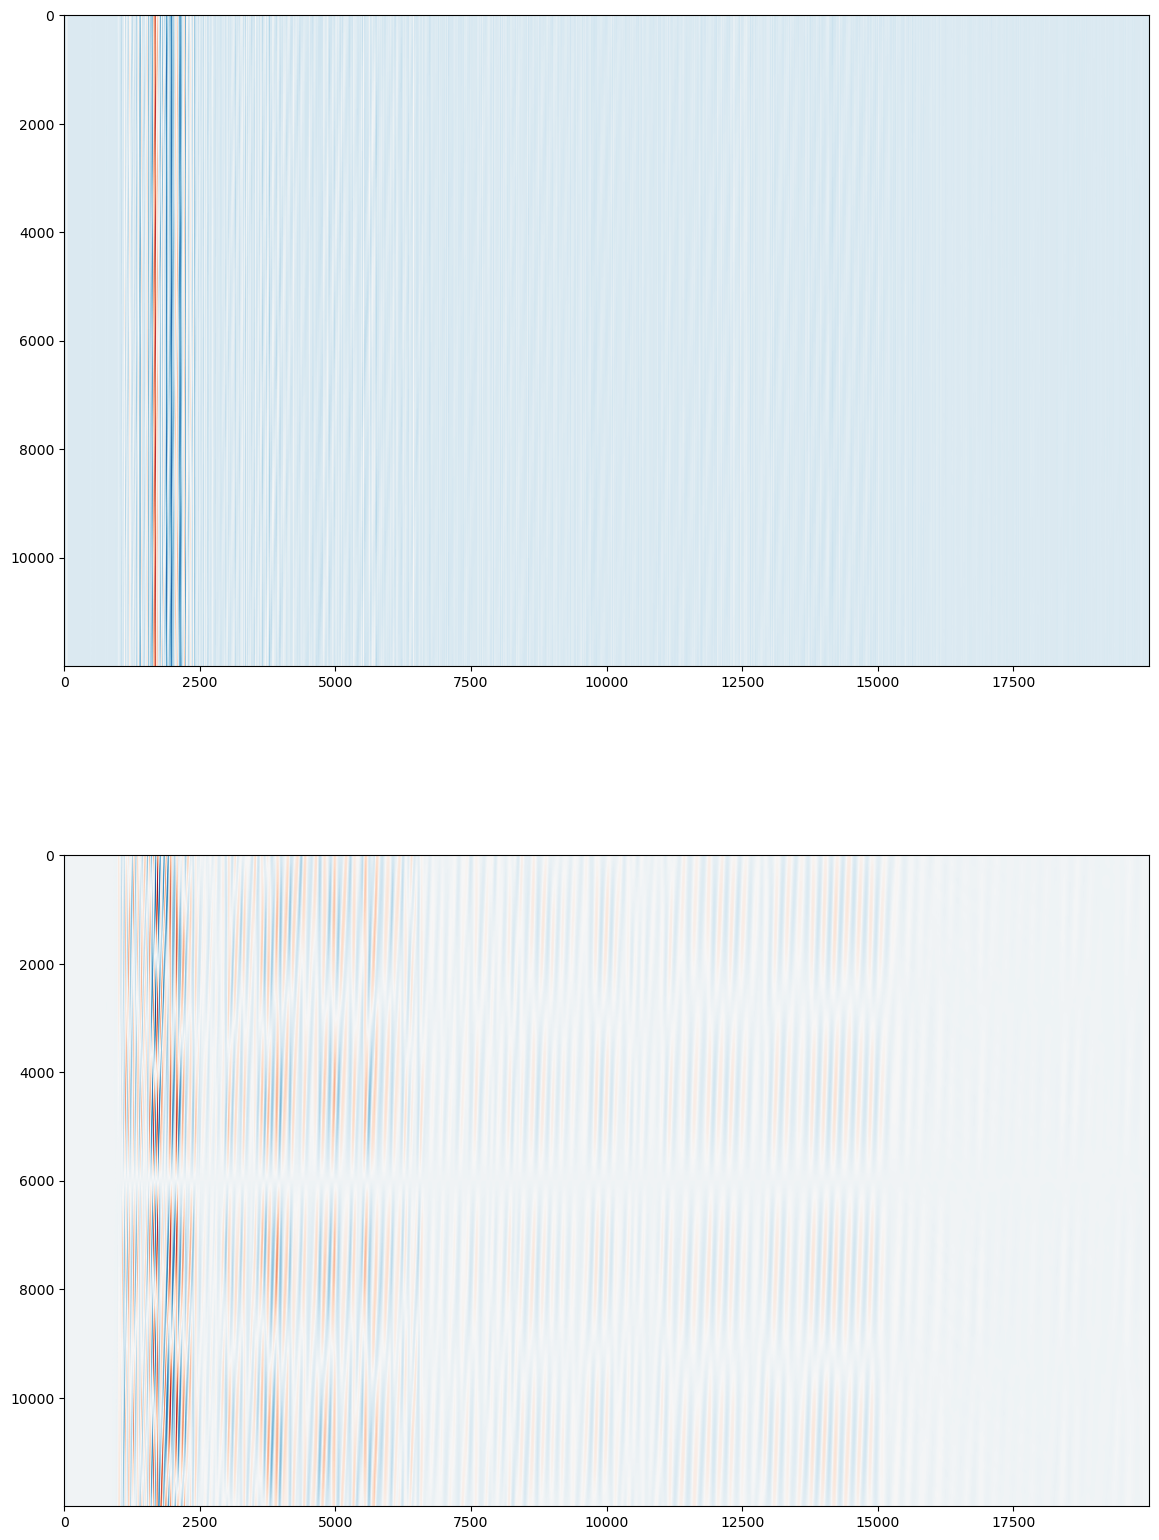

In [29]:
fig,ax=plt.subplots(2,figsize=(14,20))
ax[0].imshow(a, cmap='RdBu')
ax[1].imshow(f, cmap='RdBu')
fig.show()

In [30]:
cols=['k', 'xkcd:maroon', 'xkcd:red', 'xkcd:red orange', 
      'xkcd:orange', 'xkcd:golden yellow', 'xkcd:bright yellow', 
      'xkcd:greenish yellow', 'xkcd:green', 'xkcd:greenish cyan', 
      'xkcd:cyan', 'xkcd:light light blue', 'xkcd:light blue', 
      'xkcd:blue', 'xkcd:purple', 'xkcd:dark purple']
ncols = len(cols)
print('There are', ncols, 'colors in the current color wheel.')

There are 16 colors in the current color wheel.


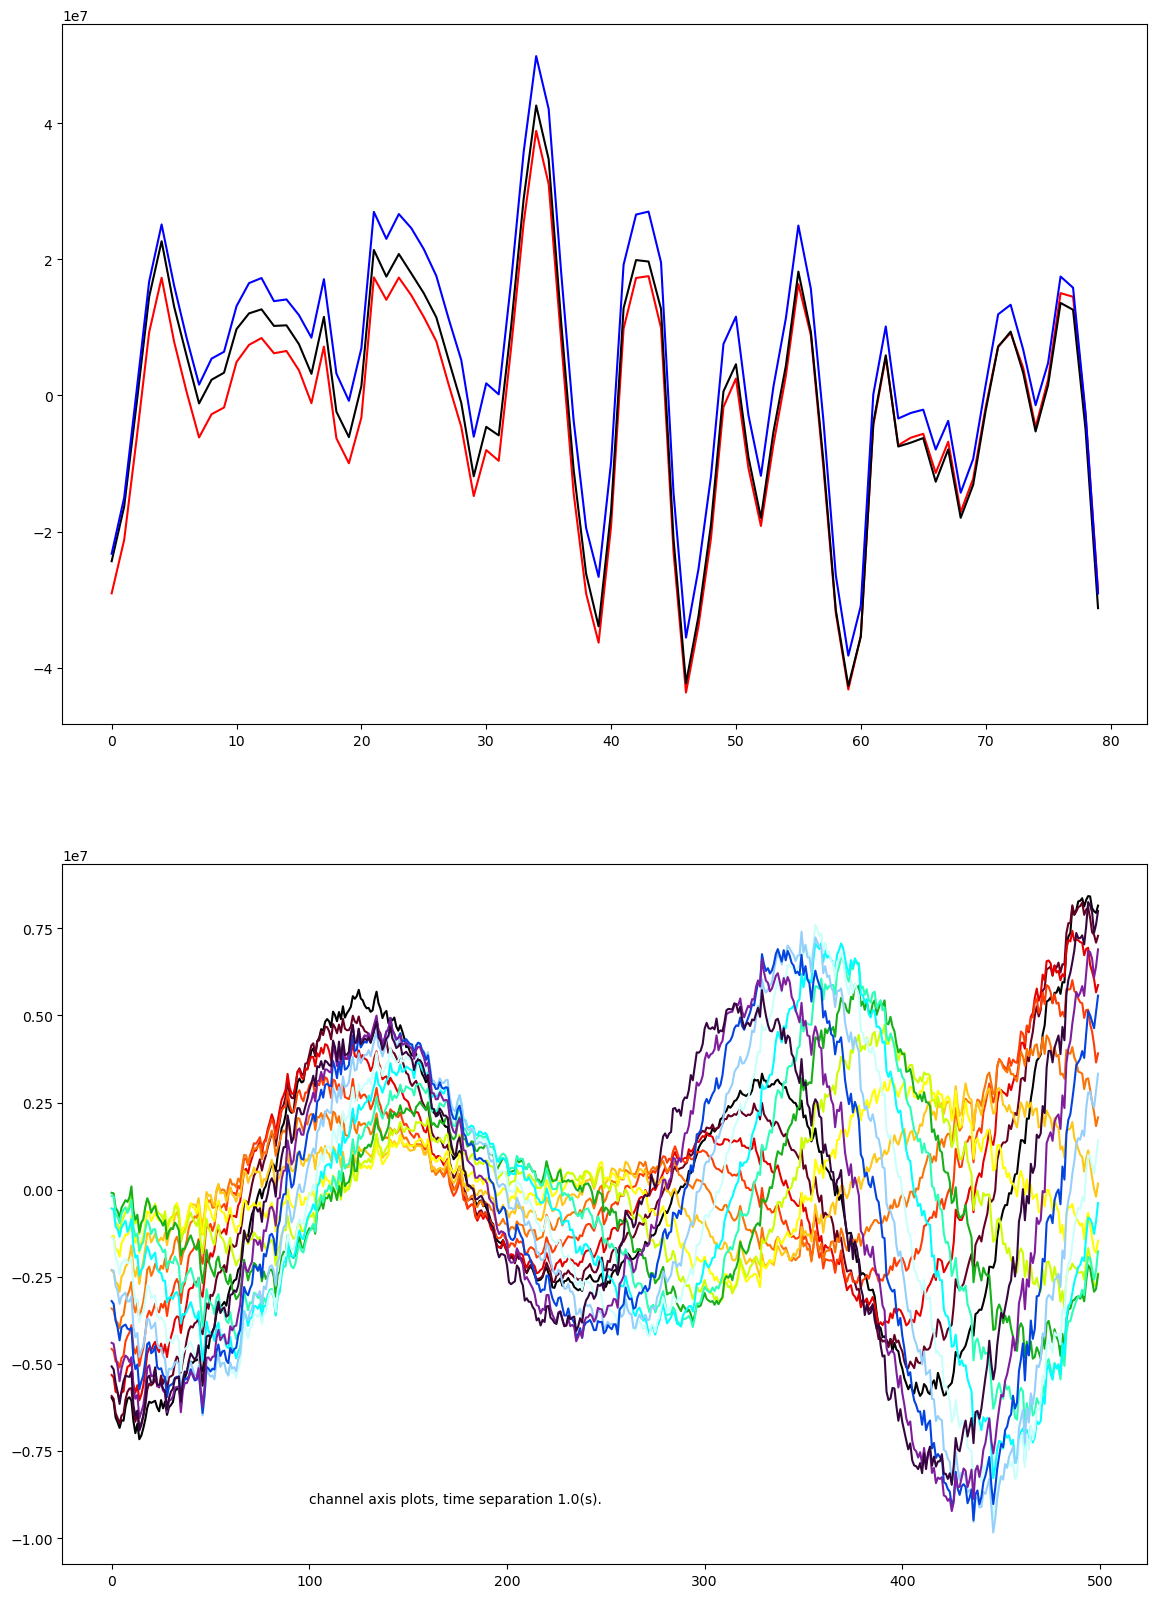

In [33]:
# set up a double chart
fig,ax=plt.subplots(2,figsize=(14,20))

# top chart is along the channel axis, no archetype subtraction.
#   This shows the cable 'signature' stability
pulse0, pulseMid, pulseN = 0, 6000, 11999           # Time separation (sec) = delta-pulse / 200
pulseChan0, pulseChanN = 13820, 13900               # Channel range x 2 = seismometer span (m)

ax[0].plot(a[pulse0,   pulseChan0:pulseChanN], c='red')
ax[0].plot(a[pulseMid, pulseChan0:pulseChanN], c='black')
ax[0].plot(a[pulseN,   pulseChan0:pulseChanN], c='blue')

# lower chart is along the channel axis, many residues
chanstart  = 12500
chanend    = 13000

pulsestart = 8000           # was 9000      # was 6000
pulseend   = 11000          # was 11000     #     8000
pulsestep  =  200

for i in range(pulsestart, pulseend + 1, pulsestep):
    j = (i - pulsestart)//pulsestep
    ax[1].plot(f[i, chanstart:chanend], c=cols[j%ncols])

timesepstring = str(round(pulsestep/200., 1))
msg = 'channel axis plots, time separation ' + timesepstring + '(s)'
ax[1].text(100, -.9e7, msg)
fig.show()

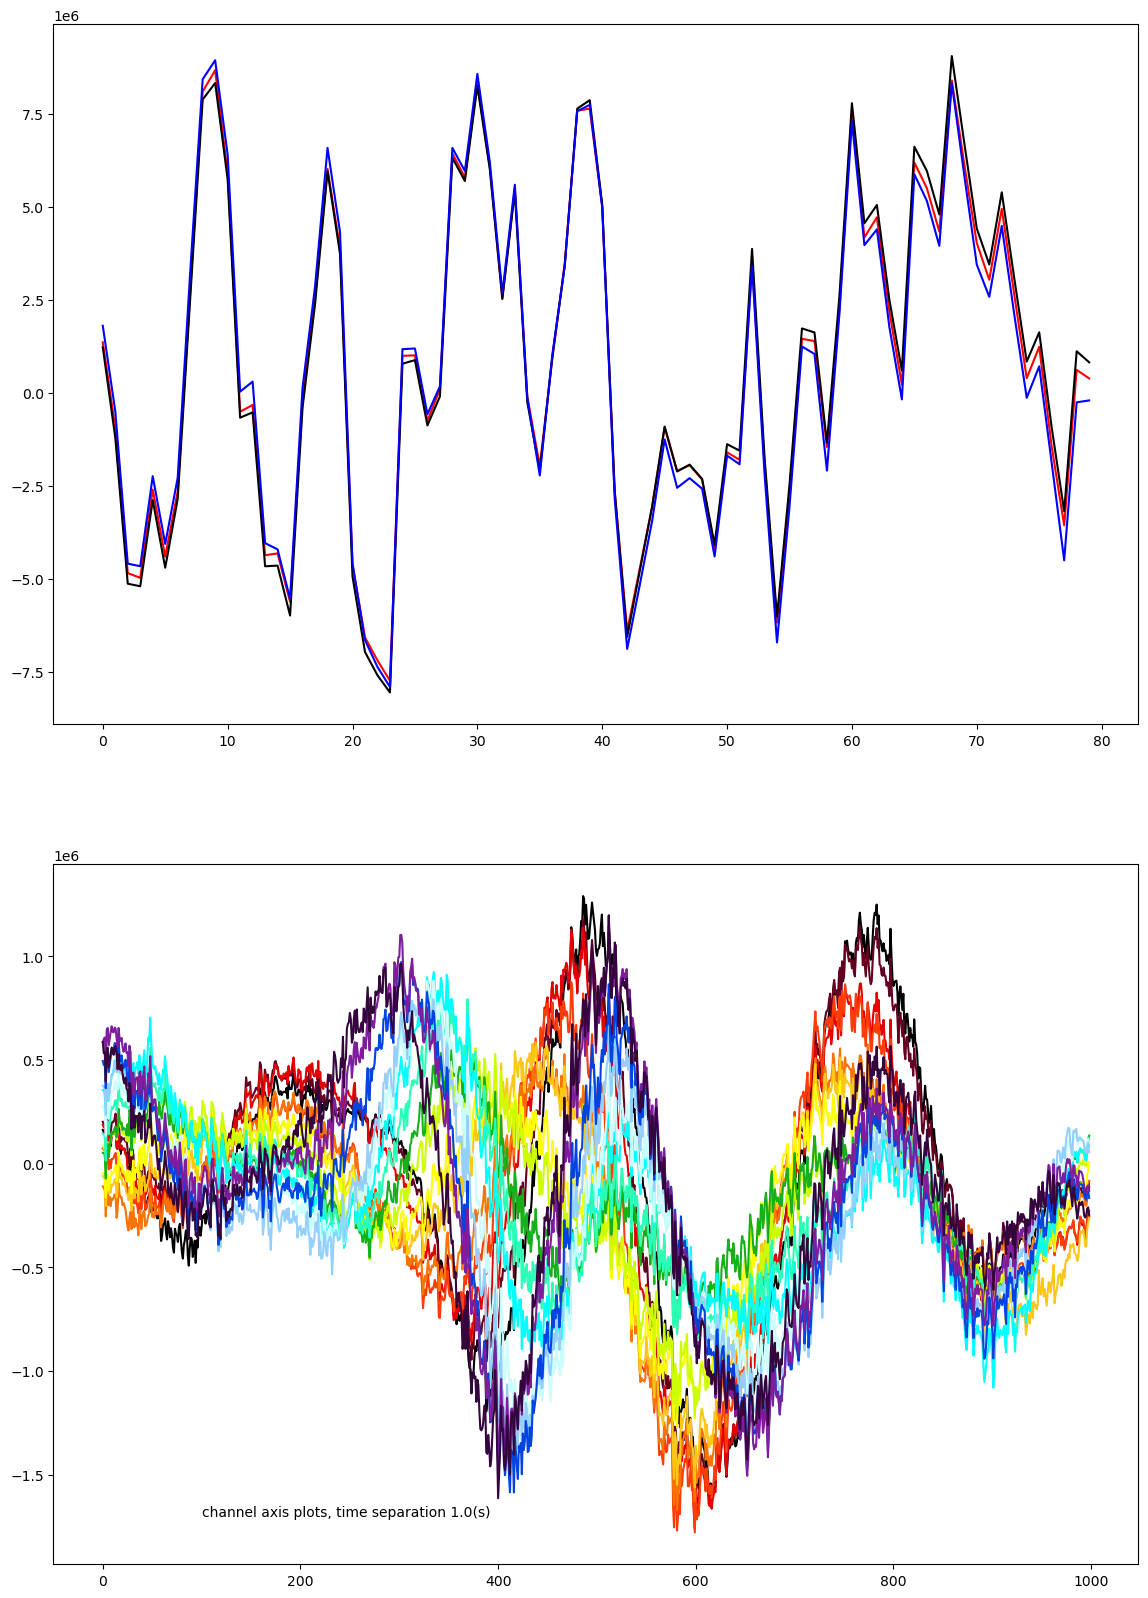

In [64]:
# Identical to above: Change parameters to look somewhere else

# set up a double chart
fig,ax=plt.subplots(2,figsize=(14,20))

# top chart is along the channel axis, no archetype subtraction.
#   This shows the cable 'signature' stability
pulse0, pulseMid, pulseN = 0, 6000, 11999           # Time separation (sec) = delta-pulse / 200
pulseChan0, pulseChanN = 19500, 19580               # Channel range x 2 = seismometer span (m)

ax[0].plot(a[pulse0,   pulseChan0:pulseChanN], c='red')
ax[0].plot(a[pulseMid, pulseChan0:pulseChanN], c='black')
ax[0].plot(a[pulseN,   pulseChan0:pulseChanN], c='blue')

# lower chart is along the channel axis, many residues
chanstart  = 19000
chanend    = 19999

pulsestart = 8000           # was 9000      # was 6000
pulseend   = 11000          # was 11000     #     8000
pulsestep  =  200

for i in range(pulsestart, pulseend + 1, pulsestep):
    j = (i - pulsestart)//pulsestep
    ax[1].plot(f[i,chanstart:chanend], c=cols[j%ncols])

timesepstring = str(round(pulsestep/200., 1))
msg = 'channel axis plots, time separation ' + timesepstring + '(s)'
ax[1].text(100, -1.7e6, msg)          # change manually to get message in a good location
fig.show()

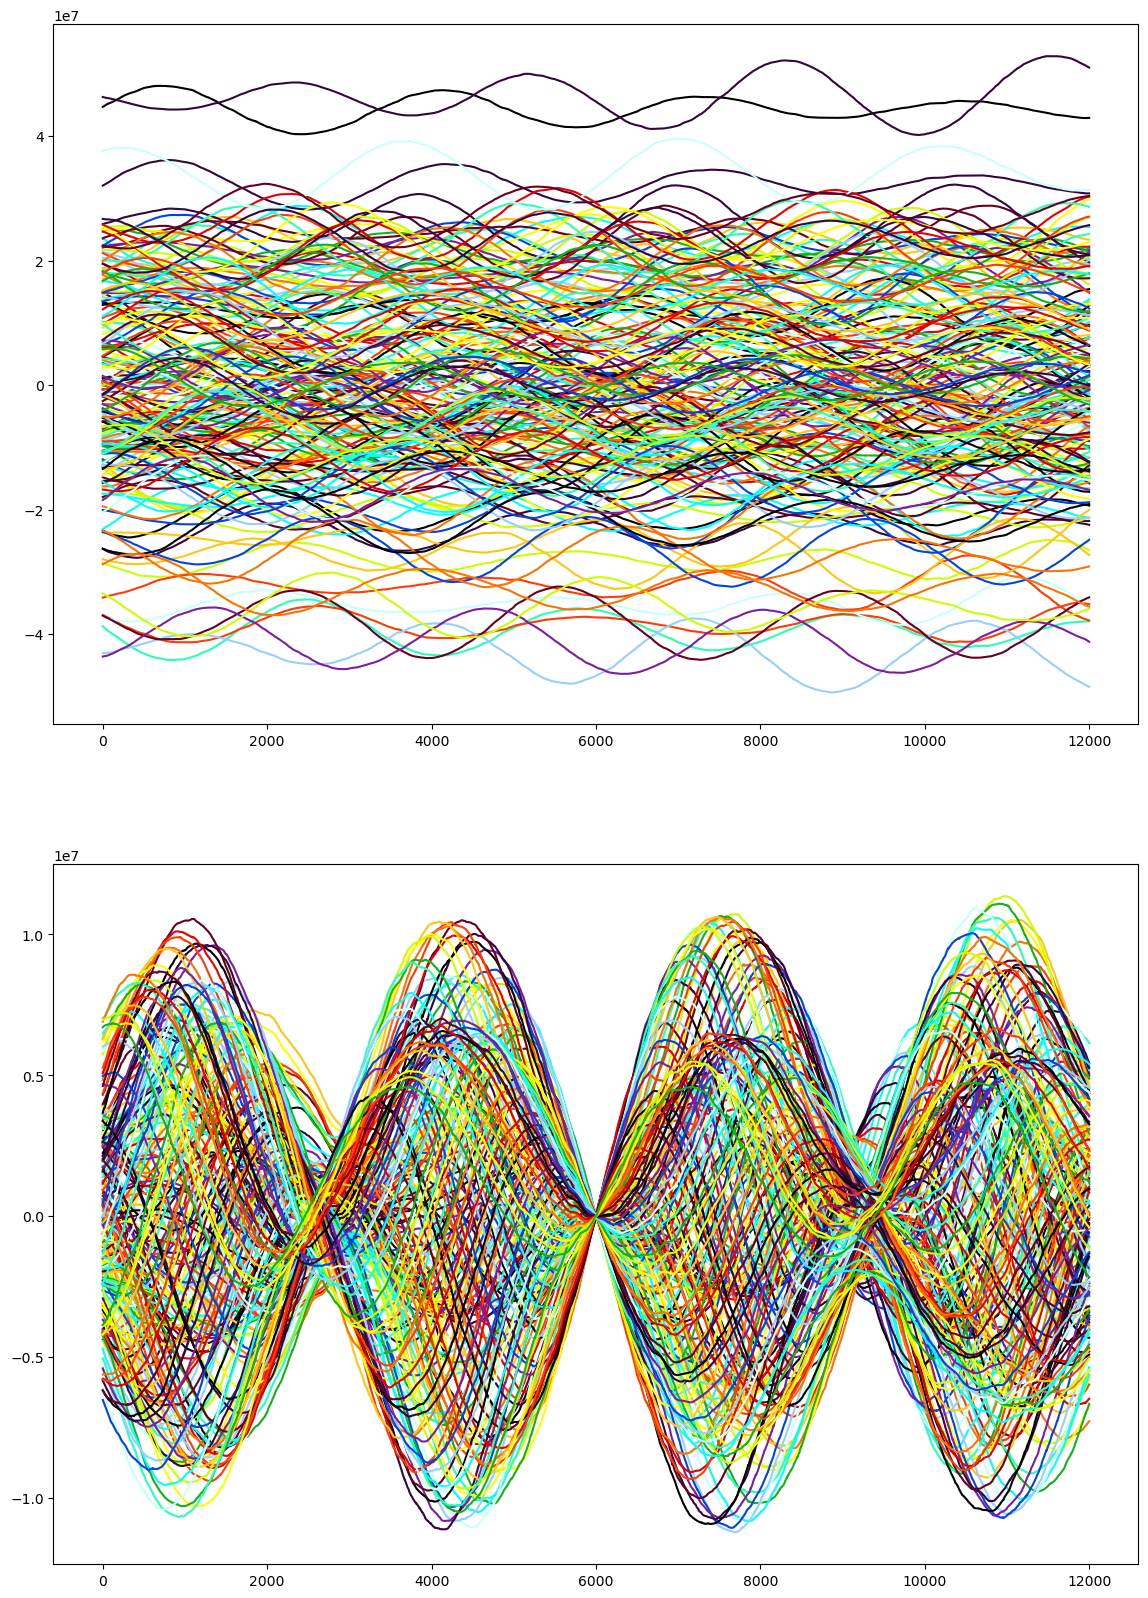

In [51]:
# set up a double chart
fig,ax=plt.subplots(2, figsize=(14,20))

# top chart is along the pulse axis, several fixed channels, no archetype subtraction.

pulse0, pulseN          = 0, 12000           # Time separation (sec) = delta-pulse / 200
chan0, chanN, chanDelta = 12500, 13500, 5    # Channel range x 2 = seismometer span (m)

for chan in range(chan0, chanN + 1, chanDelta):
    j = (chan - chan0) // chanDelta
    ax[0].plot(a[pulse0:pulseN, chan], c=cols[j%ncols])
    
# ax[0].text(100, 4.4e7, 
#     'pulse axis plots, raw data (no archetype removal results in variability +-4e7)')

for chan in range(chan0, chanN + 1, chanDelta):
    j = (chan - chan0) // chanDelta
    ax[1].plot(f[pulse0:pulseN, chan], c=cols[j%ncols])
    
# ax[1].text(100, 1.4e7, 
#     'pulse axis residue plots, variability +-1e7')


fig.show()

In [70]:
mean_archetype=np.mean(a,axis=0)
g=np.zeros((dlen, dwid))
for i in range(dlen): g[i] = a[i] - mean_archetype[:]

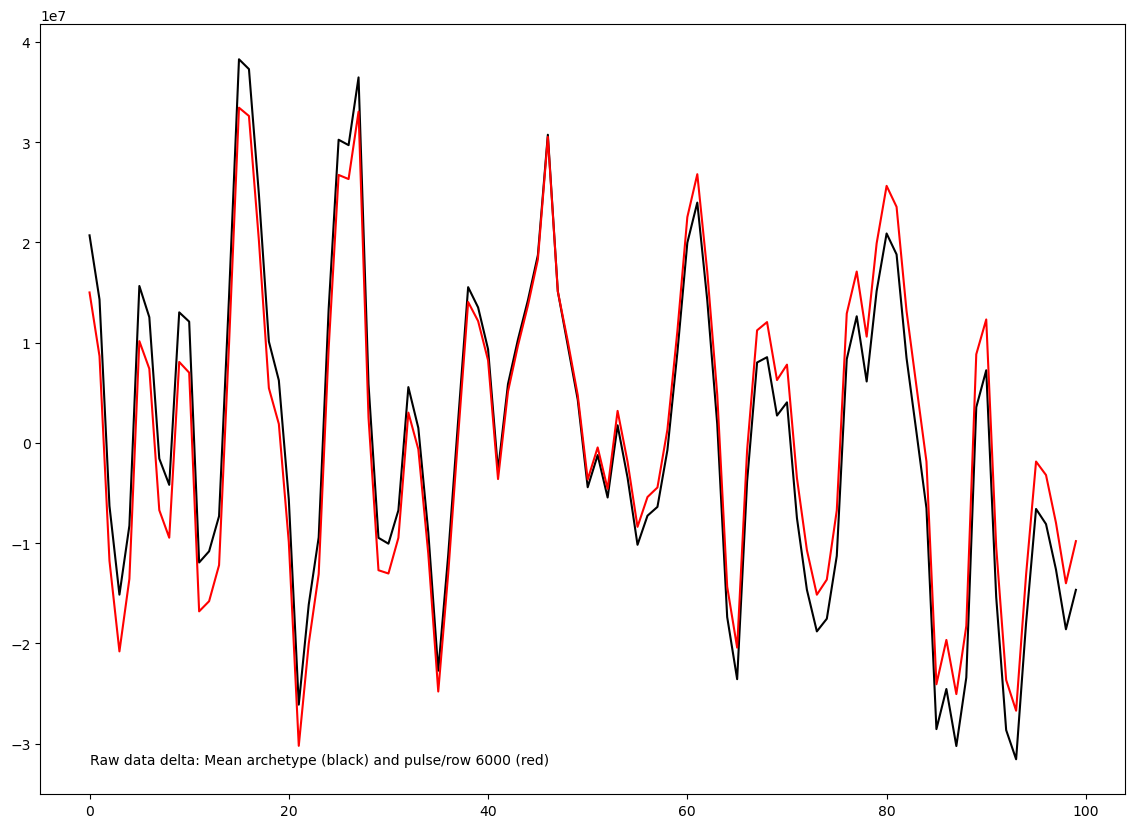

In [84]:
fig,ax=plt.subplots(figsize=(14,10))
c0 = 10000
c1 = 10100
ax.plot(chanref[c0:c1],c='k')
ax.plot(mean_archetype[c0:c1],c='r')
ax.text(0, -3.2e7, 
        'Raw data delta: Mean archetype (black) and pulse/row 6000 (red)')
fig.show()

In [74]:
print()
print('G')
print(g.size)
print(g.ndim)
print(g.shape)
print(type(g[0]))
print(type(g[0,0]))


G
240000000
2
(12000, 20000)
<class 'numpy.ndarray'>
<class 'numpy.float64'>


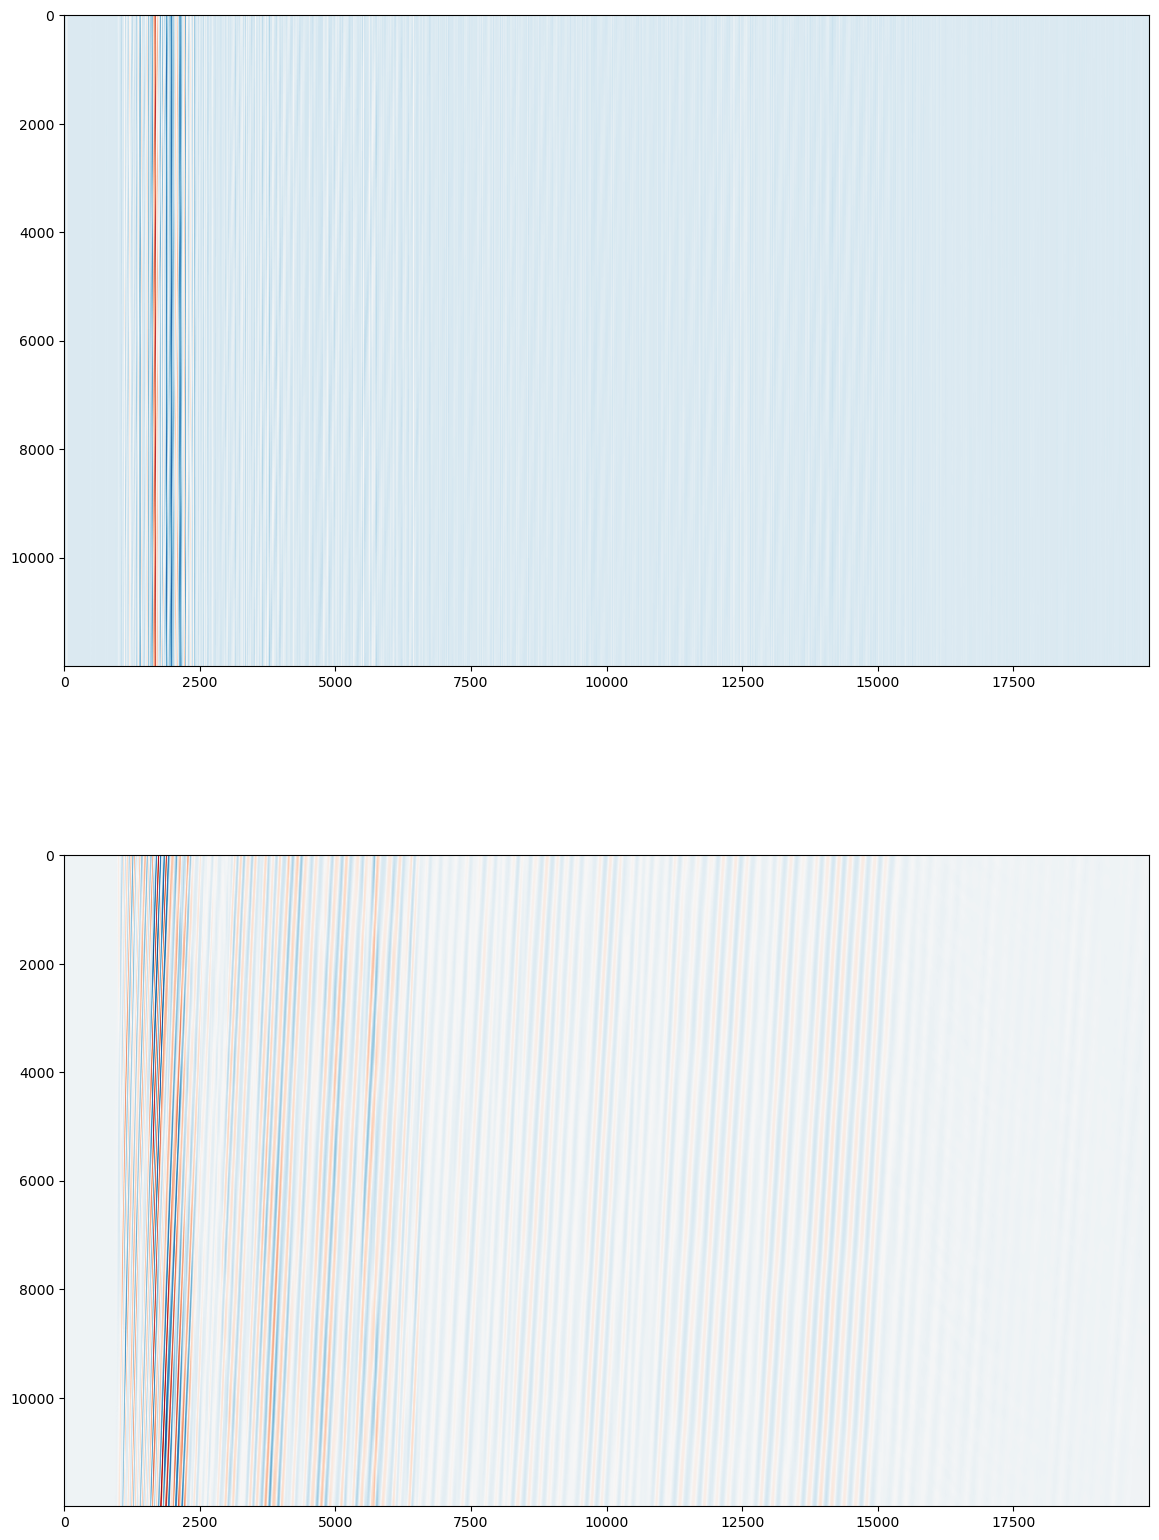

In [75]:
fig,ax=plt.subplots(2,figsize=(14,20))
ax[0].imshow(a, cmap='RdBu')
ax[1].imshow(g, cmap='RdBu')
fig.show()

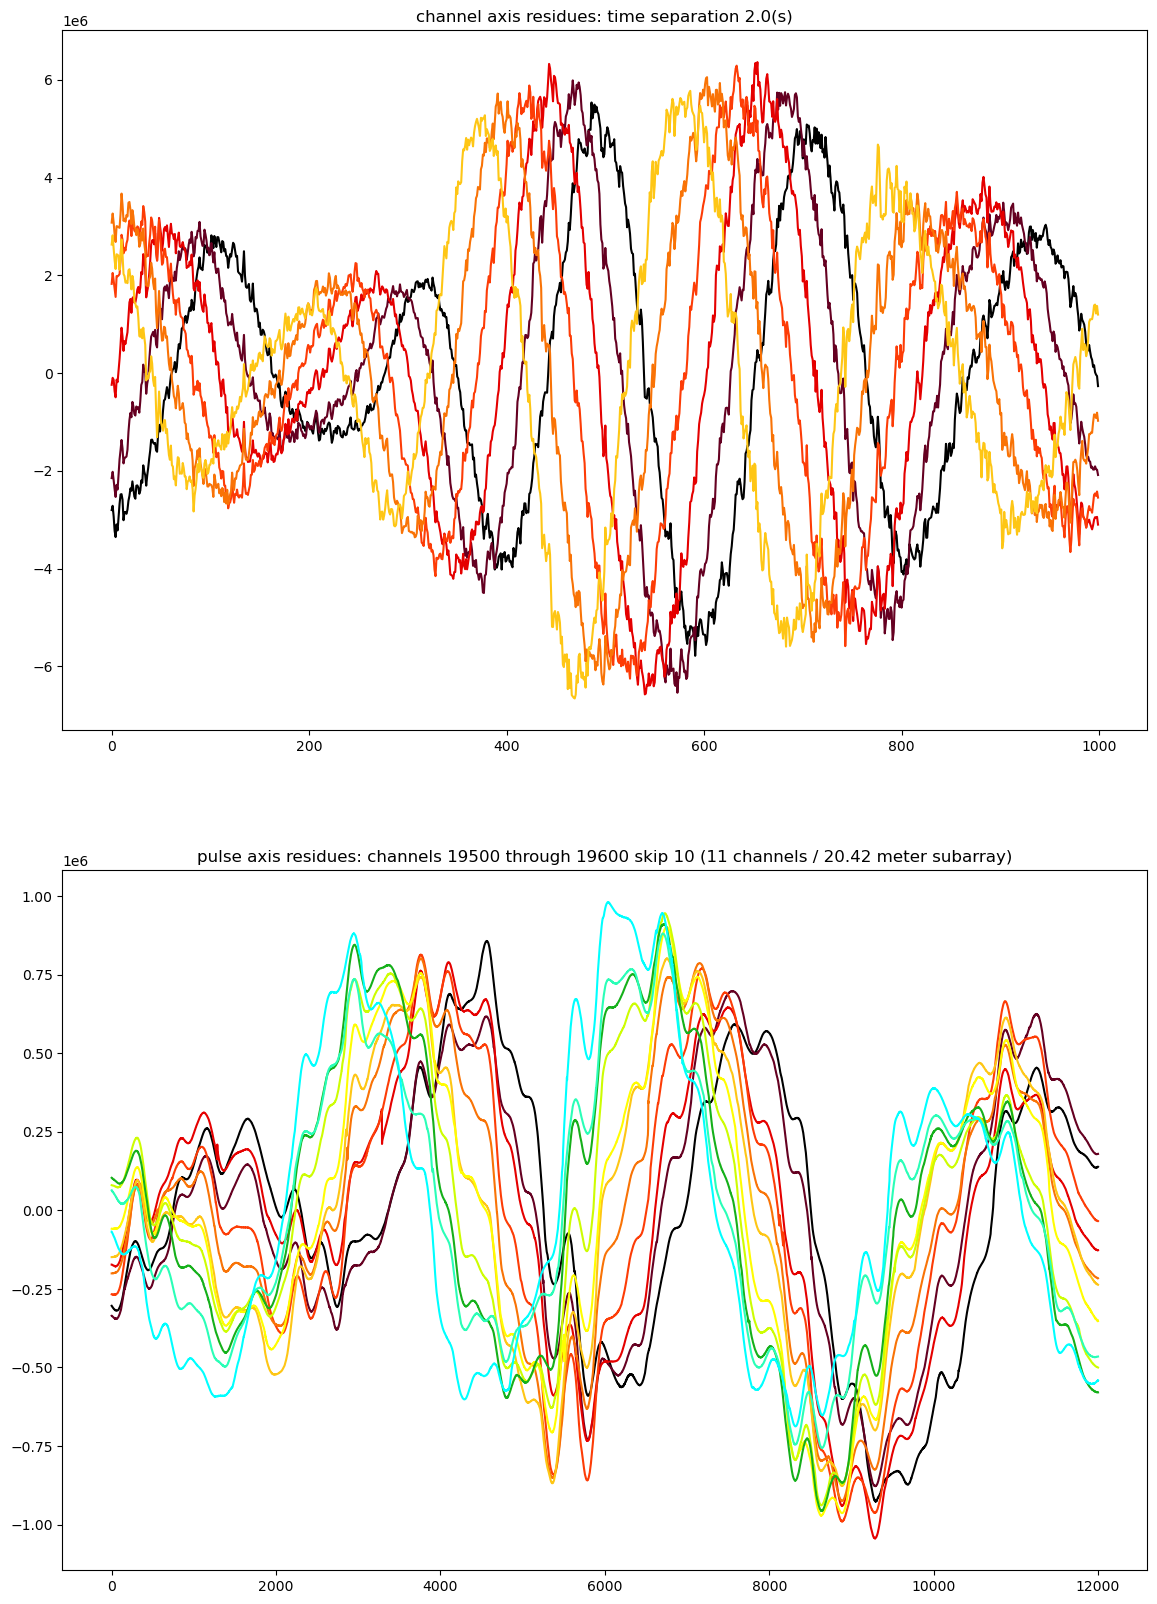

In [100]:
# set up a double chart: First channel axis, then pulse axis below that
#   - Substitute 'g' for 'f' as the data source: 
#     - g = a - mean_archetype rather than 'pulse 6000'

fig,ax=plt.subplots(2,figsize=(14,20))

# top chart is along the channel axis, no archetype subtraction.
#   This shows the cable 'signature' stability
# pulse0, pulseMid, pulseN = 0, 6000, 11999           # Time separation (sec) = delta-pulse / 200
# pulseChan0, pulseChanN = 13820, 13900               # Channel range x 2 = seismometer span (m)
# ax[0].plot(a[pulse0,   pulseChan0:pulseChanN], c='red')

# Upper chart: along the channel axis: residual
chanstart  = 12500
chanend    = 13500

pulsestart = 8000           # was 9000      # was 6000
pulseend   = 10000          # was 11000     #     8000
pulsestep  =  400

for i in range(pulsestart, pulseend + 1, pulsestep):
    j = (i - pulsestart)//pulsestep
    ax[0].plot(g[i, chanstart:chanend], c=cols[j%ncols])

timesepstring = str(round(pulsestep/200., 1))
msg = 'channel axis residues: time separation ' + timesepstring + '(s)'
ax[0].set(title=msg)

# Lower chart: Along the pulse axis; residual
#   Simple sinusoids are easy to find closer to shore, e.g. 12500, 12600, 10
pulse0, pulseN          = 0, 12000            # Time separation (sec) = delta-pulse / 200
chan0, chanN, chanDelta = 19500, 19600, 10    # Channel range x 2 = seismometer span (m)    

for chan in range(chan0, chanN + 1, chanDelta):
    j = (chan - chan0) // chanDelta
    ax[1].plot(g[pulse0:pulseN, chan], c=cols[j%ncols])

nchan = (chanN - chan0)//chanDelta + 1
subarray_size = (nchan - 1)*m_per_chan
msg = 'pulse axis residues: channels ' + str(chan0) + \
      ' through ' + str(chanN) + ' skip ' + str(chanDelta) + \
      ' (' + str(nchan) + ' channels / ' + \
      str(round(subarray_size, 2)) + ' meter subarray)'
ax[1].set(title=msg)

fig.show()